<a href="https://colab.research.google.com/github/moatezoueslati/PI_DS/blob/main/mem_odoc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Link to the original code : https://github.com/archit31uniyal/DC-Gnet?fbclid=IwAR1Q7hJxZi9TZhak0FkduttbNEpEFxQtgGzt_RvnEop3nB-i8YtohusOqIU

#Importations

In [76]:
from skimage.transform import resize
import cv2
from tensorflow.keras.models import Sequential
import numpy as np
from PIL import Image
import imutils
from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf
!pip install image-dataset-loader
from image_dataset_loader import load
import matplotlib.pyplot as plt
import os
import keras
from keras import losses
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Input, MaxPooling2D, AveragePooling2D, average
from keras.layers import concatenate, Conv2D, Conv2DTranspose, Dropout
from keras.optimizers import Adadelta
from keras.models import Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, UpSampling2D
from keras.layers import Convolution2D, ZeroPadding2D, Embedding, LSTM, concatenate, Lambda, Conv2DTranspose, Cropping2D
import glob
from pathlib import Path
from keras.layers import ELU, ReLU
act = ReLU
from skimage.segmentation import active_contour

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Selection des paramètres

In [77]:
# Définir les hyperparamètres d'entraînement
learning_rate = 0.41
batch_size = 8
num_epochs = 60
width = 512
height = 512

##Functions

In [78]:
#@title read_input
### image loading and preprocessing
def read_input(path):
    x = cv2.imread(path)
    x = cv2.resize(x, (256, 256))
    b, g, r = cv2.split(x)
    x = cv2.merge(r,  r, r)  # merge
    return x.reshape(256, 256, 3)/255   # H W 3 channels

In [79]:
#@title read_gt
# read the ground truth image
def read_gt(path):
    # ensures that the image is read as grayscale, meaning it will have a single channel representing the intensity values.
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (256, 256))
    return x/255.

In [80]:
#@title swap
def swap(a, b):
    return b, a

In [81]:
#@title ISNT
#Il mesure la longueur de la bordure de la cupule optique dans la direction verticale (de haut en bas) en comptant le nombre de pixels blanc dans chaque colonne
def ISNT(cup, disc, eye):
    ver_cup_len = 0
    ver_cup_dia= [] #liste de ver cup diametre

    for i in range(cup.shape[1]):#colonne
        for j in range(cup.shape[0]): #ligne
            if j == cup.shape[0]-1: # check if current row is the latset row in the cup array  If true, it means the current vertical segment has ended
                ver_cup_dia.append(ver_cup_len)
                ver_cup_len = 0
            elif cup[j][i] == 255: # current case=255 ? true so this pixel is part of the cup
                ver_cup_len += 1

     #print(len(ver_cup_dia), '\n')

    ########################

    ver_cup_diameter = max(ver_cup_dia) # represents the length of the longest vertical segment in the cup image.
    #print(ver_cup_diameter, '\n')

    ########################

    x = 0
    y = 0
    for d in range(len(ver_cup_dia)):
        if ver_cup_dia[d] == ver_cup_diameter:
            x = d # the index of the longest vertical segment
            break

    for e in range(x, len(ver_cup_dia)): # starting from the value of x in the list ver_cup_dia
        if ver_cup_dia[e] != ver_cup_diameter: #the value at index e!-=
            y = e # the index of the first occurrence after x
            break

     #print((x, y), '\n')

    #########################

    ver_cup_dia_ind = x + round((y - x)/2) #the index that corresponds to the middle point between x and y.
     #print("Vertical :", ver_cup_dia_ind) #the index of the middle point of the vertical segment in the cup image.



    ###############################################################################################
   #calcul horiz cuo dia ind
    hor_cup_len = 0
    hor_cup_dia= []

    for i in range(cup.shape[1]):
        for j in range(cup.shape[0]):
            if j == cup.shape[0]-1:
                hor_cup_dia.append(hor_cup_len)
                hor_cup_len = 0
            elif cup[i][j] == 255:
                hor_cup_len += 1

    # print(len(hor_cup_dia), '\n')

    ########################

    hor_cup_diameter = max(hor_cup_dia)
    #print(hor_cup_diameter, '\n')

    ########################

    g = 0
    h = 0
    for d in range(len(hor_cup_dia)):
        if hor_cup_dia[d] == hor_cup_diameter:
            g = d
            break

    for e in range(x, len(hor_cup_dia)):
        if hor_cup_dia[e] != hor_cup_diameter:
            h = e
            break

     #print((g, h), '\n')

    #########################

    hor_cup_dia_ind = g + round((h - g)/2)
     #print("Horizontal :", hor_cup_dia_ind)

    ###########################################################################################################
    #calcul isnt S
    disc_bound_s = 0
    for i in range(disc.shape[0]):
        if disc[i][ver_cup_dia_ind] == 0: #the pixel is part of the boundary of the disc
            disc_bound_s += 1
        elif disc[i][ver_cup_dia_ind] == 255: #the pixel is part of the interior of the disc
            break

    # print(disc_bound_s) #the number of pixels along the vertical segment in the disc image

    cup_bound_s = 0
    for i in range(cup.shape[0]):
        if cup[i][ver_cup_dia_ind] == 0: #the pixel is part of the boundary of the cup
            cup_bound_s += 1
        elif cup[i][ver_cup_dia_ind] == 255:
            break

     #print(cup_bound_s) #the number of pixels along the vertical segment in the cup  image

    isnt_s = cup_bound_s - disc_bound_s
    #print("S :", isnt_s)

    ##############################################################################################################
    #calcul isnt I
    i = list(range(disc.shape[0]))
    i.reverse()
    j = list(range(cup.shape[0]))
    j.reverse()

    disc_bound_i = 0
    cup_bound_i = 0

    for p in i:
        if disc[p][ver_cup_dia_ind] == 0:
            disc_bound_i += 1
        elif disc[p][ver_cup_dia_ind] == 255:
            break

    for q in j:
        if cup[q][ver_cup_dia_ind] == 0:
            cup_bound_i += 1
        elif cup[q][ver_cup_dia_ind] == 255:
            break

    # print(cup_bound_i, disc_bound_i, '\n')

    isnt_i = cup_bound_i - disc_bound_i
    # print("I : ", isnt_i)

    #############################################################################################################
     #calcul isnt T
    disc_bound_t = 0
    for i in range(disc.shape[1]):
        if disc[hor_cup_dia_ind][i] == 0:
            disc_bound_t += 1
        elif disc[hor_cup_dia_ind][i] == 255:
            break

     #print(disc_bound_s)

    cup_bound_t = 0
    for i in range(cup.shape[1]):
        if cup[hor_cup_dia_ind][i] == 0:
            cup_bound_t += 1
        elif cup[hor_cup_dia_ind][i] == 255:
            break

     #print(cup_bound_s)

    isnt_t = cup_bound_t - disc_bound_t
    # print("T :", isnt_t)

    #############################################################################################################
    #calcul isnt N
    i = list(range(disc.shape[1]))
    i.reverse()
    j = list(range(cup.shape[1]))
    j.reverse()

    disc_bound_n = 0
    cup_bound_n = 0

    for p in i:
        if disc[hor_cup_dia_ind][p] == 0:
            disc_bound_n += 1
        elif disc[hor_cup_dia_ind][p] == 255:
            break

    for q in j:
        if cup[hor_cup_dia_ind][q] == 0:
            cup_bound_n += 1
        elif cup[hor_cup_dia_ind][q] == 255:
            break

    isnt_n = cup_bound_n - disc_bound_n
    # print("N : ", isnt_n)

    #############################################################################################################

    cup_dias = [ver_cup_diameter, hor_cup_diameter]

    if eye == 'r':
        isnt_n, isnt_t = swap(isnt_n, isnt_t)

    return list([isnt_i, isnt_s, isnt_n, isnt_t]), cup_dias




In [82]:
#@title DDLS
def DDLS(cup_img, disc_img, precision_angle=10):

    rim_ind_line = []

    min_rim = []
    disc_diameter = []

    disc_dias = []

    ##############################################

    for angle in np.arange(0, 360, precision_angle):
        cup = cup_img.rotate(angle)
        disc = disc_img.rotate(angle)

        #################################

        cup = np.array(cup)
        disc = np.array(disc)

        #################################
        #calcul cup boundary
        cup_width = []
        cup_boundary = 0
        for i in range(cup.shape[1]):
            for j in range(cup.shape[0]):
                if j == cup.shape[0]-1: # boucle a atteint la derniere ligne
                    cup_width.append(cup_boundary)
                    cup_boundary = 0
                    break
                elif cup[j][i] == 255: # la boucle a trouvé une limite de la cupule
                    cup_width.append(cup_boundary)
                    cup_boundary = 0
                    break
                else:
                    cup_boundary += 1

        #################################

        n = 0
        m = 0
        for s in range(len(cup_width)):
            if cup_width[s] != 511:
                n = s
                break

        for t in range(n, len(cup_width)):
            if cup_width[t] == 511:
                m = t
                break

        #################################
        #calcul disc boundary
        disc_width = []
        disc_boundary = 0

        for k in range(n, m):
            for l in range(disc.shape[0]):
                if l == disc.shape[0]-1:
                    disc_width.append(disc_boundary)
                    disc_boundary = 0
                    break
                elif disc[l][k] == 255:
                    disc_width.append(disc_boundary)
                    disc_boundary = 0
                    break
                else:
                    disc_boundary += 1

        #################################

        cup_width = np.array(cup_width[n:m])
        disc_width = np.array(disc_width)

        #################################

        rim_width = cup_width - disc_width
        min_rim.append(min(rim_width))

        line_ind = np.where(rim_width == min(rim_width))[0] #trouver les indices où les valeurs de rim_width sont égales au minimum précédemment calculé.

        rim_ind_line.append(n + line_ind[len(line_ind)//2])

        #################################
        #calcul disc diameter
        diameter = []
        dia = 0
        for p in range(disc.shape[1]):
            for q in range(disc.shape[0]):
                if q == disc.shape[0] - 1: # la boucle a atteint la dernière ligne de l'image du disque
                    if dia > 0:
                        diameter.append(dia)
                    dia = 0
                    break
                if disc[q][p] == 255: #la boucle a trouvé une partie du disque optique
                    dia += 1

        disc_diameter.append(max(diameter))

        # 0-vertical    # 1-hor

        if angle == 0 or angle == 90:
            disc_dias.append(max(diameter))

    ##############################################

    print("Minimum Rim Width : {}".format(min(min_rim)))
    print("Disc Diameter : {}".format(max(disc_diameter)), '\n')

    return min(min_rim)/max(disc_diameter), disc_dias, min(min_rim), min_rim.index(min(min_rim))*precision_angle, rim_ind_line[min_rim.index(min(min_rim))]

###IoU

In [113]:
def calculate_iou(pred_mask, true_mask):
    intersection = np.logical_and(pred_mask, true_mask)
    union = np.logical_or(pred_mask, true_mask)
    iou = np.sum(intersection) / np.sum(union)
    return iou

###Dice similarity

In [84]:
def calculate_dice(pred_mask, true_mask):
    intersection = np.logical_and(pred_mask, true_mask)
    dice = (2.0 * np.sum(intersection)) / (np.sum(pred_mask) + np.sum(true_mask))
    return dice


###Accuracy

In [85]:
def calculate_accuracy(pred_mask, true_mask):
    # Convert masks to boolean arrays
    pred_mask = pred_mask.astype(bool)
    true_mask = true_mask.astype(bool)

    # Calculate accuracy
    accuracy = np.sum(pred_mask == true_mask) / pred_mask.size
    return accuracy

###Sensitivity

In [86]:
def calculate_sensitivity(pred_mask, true_mask):
    # Convert masks to boolean arrays
    pred_mask = pred_mask.astype(bool)
    true_mask = true_mask.astype(bool)

    # Calculate true positives and false negatives
    true_positives = np.sum(np.logical_and(pred_mask, true_mask))
    false_negatives = np.sum(np.logical_and(~pred_mask, true_mask))

    # Calculate sensitivity (recall)
    sensitivity = true_positives / (true_positives + false_negatives)
    return sensitivity

#Image Reading

In [87]:
#path='/content/drive/MyDrive/Drishti-GS1/DS1/DS2/Test/Images/D1.png'
#cup_path = '/content/drive/MyDrive/Drishti-GS1/DS1/DS2/Test/Test_GT/drishtiGS_001/SoftMap/cup.png'
#disc_path = '/content/drive/MyDrive/Drishti-GS1/DS1/DS2/Test/Test_GT/drishtiGS_001/SoftMap/disc.png'
photoname = 'N-16-R.png'
path = '/content/drive/MyDrive/N-16-R.png'
cup_path = '/content/drive/MyDrive/N-16-R-Cup-Avg.png'
disc_path = '/content/drive/MyDrive/N-16-R-Disc-Avg.png'


##read image in red channel

Text(0.5, 1.0, 'Image original')

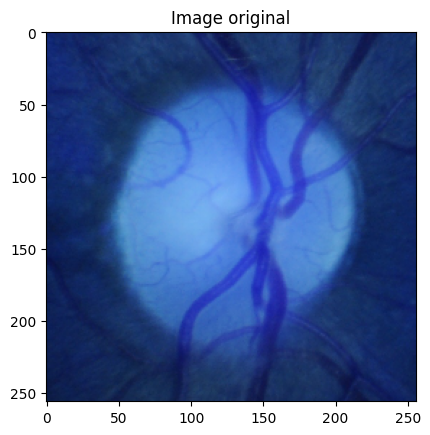

In [88]:
contour_img = np.array(Image.open(path))  # converts img original into a NumPy array. RGB
img = cv2.imread(path) #BGR
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256))

plt.figure()
plt.imshow(img)
plt.title('Image original')

##Get red channel

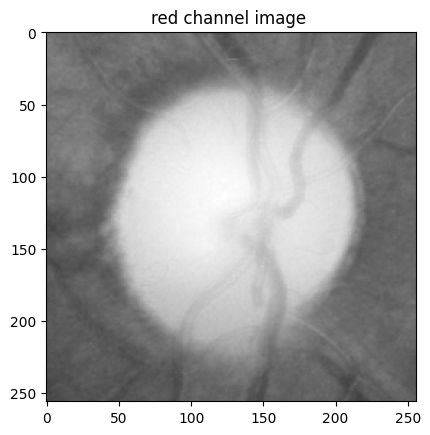

In [89]:
b, g, r = cv2.split(img)
#eya
# Créer un objet CLAHE avec les paramètres souhaités
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
r_clahe = clahe.apply(r)
img_r = cv2.merge((r, r, r))/255.
# Normalisation de l'image
max_value = np.max(img_r)
img_r = img_r / max_value
plt.figure()
plt.imshow(img_r)
plt.title('red channel image ')
true_cup = cv2.imread(cup_path, cv2.IMREAD_GRAYSCALE)
true_disc = cv2.imread(disc_path, cv2.IMREAD_GRAYSCALE)

#Model et architecture

In [90]:
#@title get_unet
# do détermine le taux de dropout, c'est-à-dire la proportion de neurones à désactiver.
#reduire surapprentissage
def get_unet(do=0, activation=act):
    inputs = Input((None, None, 3))
    conv1 = Dropout(do)(activation()(Conv2D(32, (4, 4), padding='same')(inputs)))
    conv1 = Dropout(do)(activation()(Conv2D(32, (4, 4), padding='same')(conv1)))
    pool1 = MaxPooling2D(pool_size=(4, 4))(conv1)

    conv2 = Dropout(do)(activation()(Conv2D(64, (4, 4), padding='same')(pool1)))
    conv2 = Dropout(do)(activation()(Conv2D(64, (4, 4), padding='same')(conv2)))
    pool2 = MaxPooling2D(pool_size=(4, 4))(conv2)

    conv3 = Dropout(do)(activation()(Conv2D(128, (4, 4), padding='same')(pool2)))
    conv3 = Dropout(do)(activation()(Conv2D(128, (4, 4), padding='same')(conv3)))
    pool3 = MaxPooling2D(pool_size=(4, 4))(conv3)

    conv4 = Dropout(do)(activation()(Conv2D(128, (4, 4), padding='same')(pool3)))
    conv4 = Dropout(do)(activation()(Conv2D(128, (4, 4), padding='same')(conv4)))
    pool4 = MaxPooling2D(pool_size=(4, 4))(conv4)

    conv5 = Dropout(do)(activation()(Conv2D(128, (4, 4), padding='same')(pool4)))
    conv5 = Dropout(do)(activation()(Conv2D(128, (4, 4), padding='same')(conv5)))

    up6 = concatenate([UpSampling2D(size=(4, 4))(conv5), conv4], axis=3)
    conv6 = Dropout(do)(activation()(Conv2D(128, (3, 3), padding='same')(up6)))
    conv6 = Dropout(do)(activation()(Conv2D(128, (3, 3), padding='same')(conv6)))

    up7 = concatenate([UpSampling2D(size=(4, 4))(conv6), conv3], axis=3)
    conv7 = Dropout(do)(activation()(Conv2D(64, (3, 3), padding='same')(up7)))
    conv7 = Dropout(do)(activation()(Conv2D(64, (3, 3), padding='same')(conv7)))

    up8 = concatenate([UpSampling2D(size=(4, 4))(conv7), conv2], axis=3)
    conv8 = Dropout(do)(activation()(Conv2D(64, (3, 3), padding='same')(up8)))
    conv8 = Dropout(do)(activation()(Conv2D(64, (3, 3), padding='same')(conv8)))

    up9 = concatenate([UpSampling2D(size=(4, 4))(conv8), conv1], axis=3)
    conv9 = Dropout(do)(activation()(Conv2D(32, (3, 3), padding='same')(up9)))
    conv9 = Dropout(do)(activation()(Conv2D(32, (3, 3), padding='same')(conv9)))

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
    #model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    #model.summary()
    return model


def DeepModel(size_set=256):
    img_input = Input(shape=(size_set, size_set, 3))

    scale_img_2 = AveragePooling2D(pool_size=(2, 2))(img_input)
    scale_img_3 = AveragePooling2D(pool_size=(2, 2))(scale_img_2)
    scale_img_4 = AveragePooling2D(pool_size=(2, 2))(scale_img_3)

    conv1 = Conv2D(32, (3, 3), padding='same', activation='relu', name='block1_conv1')(img_input)
    conv1 = Conv2D(32, (3, 3), padding='same', activation='relu', name='block1_conv2')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    input2 = Conv2D(64, (3, 3), padding='same', activation='relu', name='block2_input1')(scale_img_2)
    input2 = concatenate([input2, pool1], axis=3)
    conv2 = Conv2D(64, (3, 3), padding='same', activation='relu', name='block2_conv1')(input2)
    conv2 = Conv2D(64, (3, 3), padding='same', activation='relu', name='block2_conv2')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    input3 = Conv2D(128, (3, 3), padding='same', activation='relu', name='block3_input1')(scale_img_3)
    input3 = concatenate([input3, pool2], axis=3)
    conv3 = Conv2D(128, (3, 3), padding='same', activation='relu', name='block3_conv1')(input3)
    conv3 = Conv2D(128, (3, 3), padding='same', activation='relu', name='block3_conv2')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    input4 = Conv2D(256, (3, 3), padding='same', activation='relu', name='block4_input1')(scale_img_4)
    input4 = concatenate([input4, pool3], axis=3)
    conv4 = Conv2D(256, (3, 3), padding='same', activation='relu', name='block4_conv1')(input4)
    conv4 = Conv2D(256, (3, 3), padding='same', activation='relu', name='block4_conv2')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), padding='same', activation='relu', name='block5_conv1')(pool4)
    conv5 = Conv2D(512, (3, 3), padding='same', activation='relu', name='block5_conv2')(conv5)

    up6 = concatenate(
        [Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name='block6_dconv')(conv5), conv4],
        axis=3)
    conv6 = Conv2D(256, (3, 3), padding='same', activation='relu', name='block6_conv1')(up6)
    conv6 = Conv2D(256, (3, 3), padding='same', activation='relu', name='block6_conv2')(conv6)

    up7 = concatenate(
        [Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='block7_dconv')(conv6), conv3],
        axis=3)
    conv7 = Conv2D(128, (3, 3), padding='same', activation='relu', name='block7_conv1')(up7)
    conv7 = Conv2D(128, (3, 3), padding='same', activation='relu', name='block7_conv2')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='block8_dconv')(conv7), conv2],
                      axis=3)
    conv8 = Conv2D(64, (3, 3), padding='same', activation='relu', name='block8_conv1')(up8)
    conv8 = Conv2D(64, (3, 3), padding='same', activation='relu', name='block8_conv2')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', name='block9_dconv')(conv8), conv1],
                      axis=3)
    conv9 = Conv2D(32, (3, 3), padding='same', activation='relu', name='block9_conv1')(up9)
    conv9 = Conv2D(32, (3, 3), padding='same', activation='relu', name='block9_conv2')(conv9)

    side6 = UpSampling2D(size=(8, 8))(conv6)
    side7 = UpSampling2D(size=(4, 4))(conv7)
    side8 = UpSampling2D(size=(2, 2))(conv8)
    out6 = Conv2D(1, (1, 1), activation='sigmoid', name='side_63')(side6)
    out7 = Conv2D(1, (1, 1), activation='sigmoid', name='side_73')(side7)
    out8 = Conv2D(1, (1, 1), activation='sigmoid', name='side_83')(side8)
    out9 = Conv2D(1, (1, 1), activation='sigmoid', name='side_93')(conv9)

    out10 = average([out6, out7, out8, out9])

    return Model(inputs=[img_input], outputs=[out10])



In [91]:
#@title get_unet1

def get_unet1(do=0, activation=act):
    inputs = Input((None, None, 3))
    conv1 = Dropout(do)(activation()(Conv2D(32, (4, 4), padding='same')(inputs)))
    conv1 = Dropout(do)(activation()(Conv2D(32, (4, 4), padding='same')(conv1)))
    pool1 = MaxPooling2D(pool_size=(4, 4))(conv1)

    conv2 = Dropout(do)(activation()(Conv2D(64, (4, 4), padding='same')(pool1)))
    conv2 = Dropout(do)(activation()(Conv2D(64, (4, 4), padding='same')(conv2)))
    pool2 = MaxPooling2D(pool_size=(4, 4))(conv2)

    conv3 = Dropout(do)(activation()(Conv2D(64, (4, 4), padding='same')(pool2)))
    conv3 = Dropout(do)(activation()(Conv2D(64, (4, 4), padding='same')(conv3)))
    pool3 = MaxPooling2D(pool_size=(4, 4))(conv3)

    conv4 = Dropout(do)(activation()(Conv2D(128, (4, 4), padding='same')(pool3)))
    conv4 = Dropout(do)(activation()(Conv2D(128, (4, 4), padding='same')(conv4)))
    pool4 = MaxPooling2D(pool_size=(4, 4))(conv4)

    conv5 = Dropout(do)(activation()(Conv2D(256, (4, 4), padding='same')(pool4)))
    conv5 = Dropout(do)(activation()(Conv2D(256, (4, 4), padding='same')(conv5)))

    up6 = concatenate([UpSampling2D(size=(4, 4))(conv5), conv4], axis=3)
    conv6 = Dropout(do)(activation()(Conv2D(128, (4, 4), padding='same')(up6)))
    conv6 = Dropout(do)(activation()(Conv2D(128, (4, 4), padding='same')(conv6)))

    up7 = concatenate([UpSampling2D(size=(4, 4))(conv6), conv3], axis=3)
    conv7 = Dropout(do)(activation()(Conv2D(64, (4, 4), padding='same')(up7)))
    conv7 = Dropout(do)(activation()(Conv2D(64, (4, 4), padding='same')(conv7)))

    up8 = concatenate([UpSampling2D(size=(4, 4))(conv7), conv2], axis=3)
    conv8 = Dropout(do)(activation()(Conv2D(64, (4, 4), padding='same')(up8)))
    conv8 = Dropout(do)(activation()(Conv2D(64, (4, 4), padding='same')(conv8)))

    up9 = concatenate([UpSampling2D(size=(4, 4))(conv8), conv1], axis=3)
    conv9 = Dropout(do)(activation()(Conv2D(32, (4, 4), padding='same')(up9)))
    conv9 = Dropout(do)(activation()(Conv2D(32, (4, 4), padding='same')(conv9)))

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9) #9 outout layer

    model = Model(inputs=[inputs], outputs=[conv10])
    #model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    #model.summary()
    return model
def files_with_ext(data_path, data_type):
    file_list = [file for file in os.listdir(data_path) if file.lower().endswith(data_type)]
    print(len(file_list))
    return file_list

##appel get_unet get_unet1

In [92]:
disc_model = get_unet(do=0.25, activation=act)
#disc_model.summary()
disc_model.load_weights('/content/drive/MyDrive/ODSeg_best3.h5')
#cupule optique
cup_model = get_unet1(do=0.2, activation=act)
cup_model.load_weights('/content/drive/MyDrive/CupSeg_3.h5')
#cup_model.summary()

In [93]:
metrics = ["accuracy"]
#disc_model.compile(optimizer=Adadelta(learning_rate), loss=binary_crossentropy,metrics=metrics)

#cup_model.compile(optimizer=Adadelta(learning_rate), loss=binary_crossentropy,metrics=metrics)

#Training

##Charger les données d'entrainement

In [94]:
"""
Path_trainGT='/content/drive/MyDrive/Drishti-GS1/DS1/DS2/Training/GT'
Path_trainIMG='/content/drive/MyDrive/Drishti-GS1/DS1/DS2/Training/Images'
#load name training data x_train et y_train
train_list= files_with_ext(Path_trainIMG, '.png') #liste des images
train_images = []
train_labels = []
for i in train_list:
   image = Image.open(os.path.join(Path_trainIMG, i))
   image = np.array(image)  # Convertir en tableau numpy
   image= cv2.resize(image,(512,512))
   train_images.append(np.array(image))
   file_name = os.path.splitext(os.path.basename(i))[0] #extraire le nom de fichier sans extension
   odseg_file = Image.open(os.path.join(Path_trainGT, file_name, 'SoftMap', file_name + '_ODsegSoftmap.png'))
   ocseg_file = Image.open(os.path.join(Path_trainGT, file_name, 'SoftMap', file_name + '_cupsegSoftmap.png'))
   odseg_file = np.array(odseg_file)  # Convertir en tableau numpy
   odseg_file= cv2.resize(odseg_file,(512,512))
   train_labels.append(np.array(odseg_file))
# Convertir la liste en tableau numpy
train_images = np.asarray(train_images)
train_labels = np.asarray(train_labels)

"""

"\nPath_trainGT='/content/drive/MyDrive/Drishti-GS1/DS1/DS2/Training/GT'\nPath_trainIMG='/content/drive/MyDrive/Drishti-GS1/DS1/DS2/Training/Images'\n#load name training data x_train et y_train\ntrain_list= files_with_ext(Path_trainIMG, '.png') #liste des images\ntrain_images = []\ntrain_labels = []\nfor i in train_list:\n   image = Image.open(os.path.join(Path_trainIMG, i))\n   image = np.array(image)  # Convertir en tableau numpy\n   image= cv2.resize(image,(512,512))\n   train_images.append(np.array(image))\n   file_name = os.path.splitext(os.path.basename(i))[0] #extraire le nom de fichier sans extension\n   odseg_file = Image.open(os.path.join(Path_trainGT, file_name, 'SoftMap', file_name + '_ODsegSoftmap.png'))\n   ocseg_file = Image.open(os.path.join(Path_trainGT, file_name, 'SoftMap', file_name + '_cupsegSoftmap.png'))\n   odseg_file = np.array(odseg_file)  # Convertir en tableau numpy\n   odseg_file= cv2.resize(odseg_file,(512,512))\n   train_labels.append(np.array(odseg_file)

##Model training(disc)

In [112]:
# Entraîner le modèle sur votre ensemble de données
#disc_model.fit(train_images, train_labels, batch_size=batch_size, epochs=num_epochs)

##Model training(cup)

In [96]:
# Entraîner le modèle sur votre ensemble de données
#cup_model.fit(train_images, train_labels, batch_size=batch_size, epochs=num_epochs)

#prediction

##Disc prediction

1/1 [==============================] - 1s 529ms/step
Intersection over Union (IoU): 0.9641110138509861
Dice similarity: 0.007753470769303395
Accuracy: 0.9893646240234375
Sensitivity (Recall): 0.9713129636354204


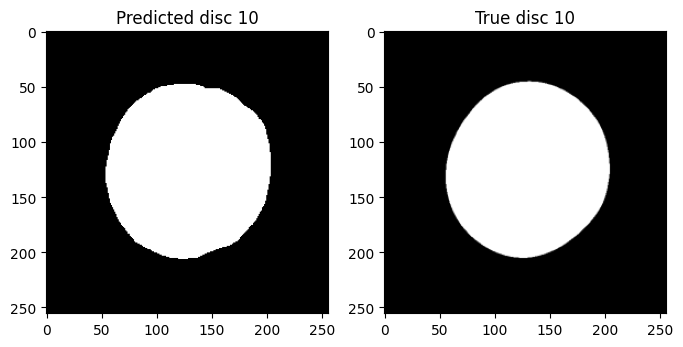

In [97]:

# In[8]:
disc_pred = disc_model.predict(np.array([img_r]))
# : This line clips the values of disc_pred between 0 and 1 using the np.clip function
disc_pred = np.clip(disc_pred, 0, 1)
# It checks if the values in disc_pred are greater than 0.5 and converts them to integers
pred_disc = (disc_pred[0, :, :, 0] > 0.5).astype(int)

pred_disc = 255*pred_disc#.*(pred_disc - np.min(pred_disc))/(np.max(pred_disc)-np.min(pred_disc))
cv2.imwrite('temp_disc.png', pred_disc)
# mask
disc = cv2.imread('temp_disc.png', cv2.IMREAD_GRAYSCALE)
# In[10]:
true_disc = resize(true_disc, (256, 256))
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
ax1.imshow(pred_disc, cmap='gray')
ax1.set_title('Predicted disc 10')
ax2.imshow(true_disc, cmap='gray')
ax2.set_title('True disc 10')

iou = calculate_iou(pred_disc, true_disc)
dice = calculate_dice(pred_disc, true_disc)
accuracy = calculate_accuracy(pred_disc, true_disc)
sensitivity = calculate_sensitivity(pred_disc, true_disc)
print("Intersection over Union (IoU):", iou)
print("Dice similarity:", dice)
print("Accuracy:", accuracy)
print("Sensitivity (Recall):", sensitivity)

##Masked disc

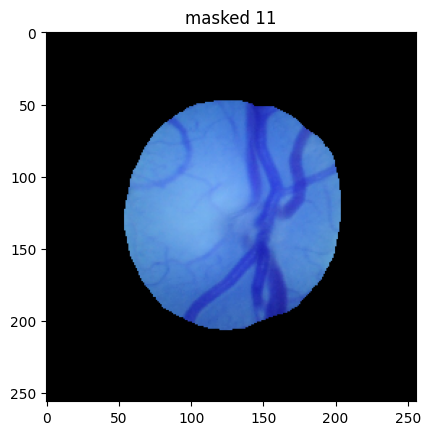

In [98]:
# In[11]:
masked = cv2.bitwise_and(img, img, mask=disc)
plt.figure()
plt.imshow(masked)
plt.title('masked 11')
mb, mg, mr = cv2.split(masked)


Text(0.5, 1.0, 'blue channel')

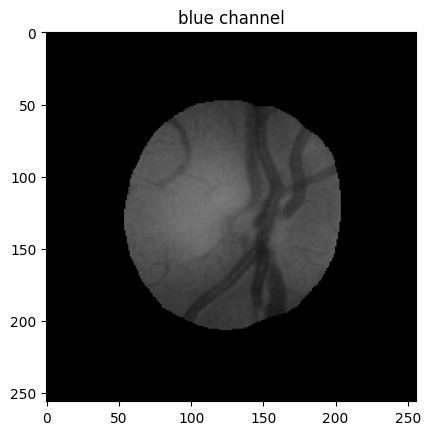

In [99]:
#eya
# Créer un objet CLAHE avec les paramètres souhaités
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
mb_clahe = clahe.apply(mb)
mg_clahe = clahe.apply(mg)

masked = cv2.merge((mb, mb, mb))

plt.figure()
plt.imshow(masked)

plt.title('blue channel')


##Cup prediction

1/1 [==============================] - 1s 577ms/step
Intersection over Union (IoU): 0.644092777907067
Dice Coefficient: 0.003141416721054075
Accuracy: 0.9824981689453125
Sensitivity (Recall): 0.7616033755274262


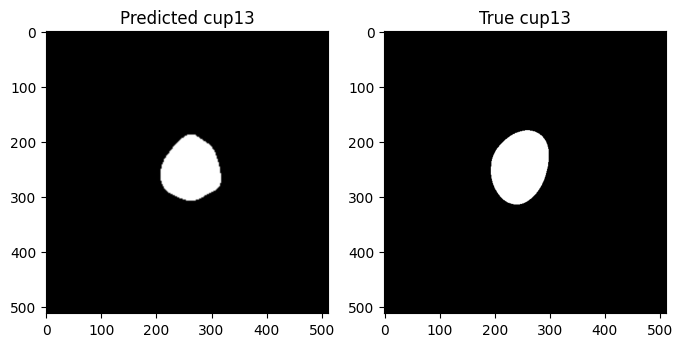

In [100]:
# In[12]:
cup_pred = cup_model.predict(np.array([masked]))
pred_cup = (cup_pred[0, :, :, 0] > 0.5).astype(int)
pred_cup = cv2.bilateralFilter(cup_pred[0, :, :, 0], 10, 40, 20)
pred_cup = (pred_cup > 0.5).astype(int)
pred_cup = resize(pred_cup, (512, 512))
pred_cup = 255.*(pred_cup - np.min(pred_cup)) /(np.max(pred_cup)-np.min(pred_cup))
cv2.imwrite('temp_cup.png', pred_cup)
# In[13]:
cup = cv2.imread('temp_cup.png', cv2.IMREAD_GRAYSCALE)

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
ax1.imshow(cup, cmap='gray')
ax2.imshow(true_cup, cmap='gray')
ax1.set_title('Predicted cup13')
ax2.set_title('True cup13')
iou = calculate_iou(pred_cup, true_cup)
dice = calculate_dice(pred_cup, true_cup)
accuracy = calculate_accuracy(pred_cup, true_cup)
sensitivity = calculate_sensitivity(pred_cup, true_cup)
print("Intersection over Union (IoU):", iou)
print("Dice Coefficient:", dice)
print("Accuracy:", accuracy)
print("Sensitivity (Recall):", sensitivity)

#Output

##create temp disc and cup

In [101]:
# In[14]:
disc = resize(disc, (512, 512))
cv2.imwrite('temp_disc.png', disc)
disc = cv2.imread('temp_disc.png', cv2.IMREAD_GRAYSCALE)
(thresh, disc) = cv2.threshold(disc, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
cv2.imwrite('temp_disc.png', disc)
(thresh, cup) = cv2.threshold(cup, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
# In[15]:
cup_img = Image.open('temp_cup.png')
disc_img = Image.open('temp_disc.png')

##calcul ISNT

In [102]:

# In[16]:
isnt, cup_dias = ISNT(cup, disc, 'r')
print("\nI : {}\nS : {}\nN : {}\nT : {}".format(
    isnt[0], isnt[1], isnt[2], isnt[3]))

if isnt[0] > isnt[1] > isnt[2] > isnt[3]:
    print("\nNot Suspicious")
else:
    print("\nSuspicious l'observation n'est pas conforme à ce qui est considéré comme normal")


I : 104
S : 92
N : 100
T : 92

Suspicious l'observation n'est pas conforme à ce qui est considéré comme normal


## calcul DDLS

In [109]:
# # DDLS

# In[17]:
ddls, disc_dias, minrim, minang, minind = DDLS(cup_img, disc_img, 5)
print("DDLS : %.5f" % ddls)

Minimum Rim Width : 86
Disc Diameter : 321 

DDLS : 0.26791


##Calcul cdr

In [110]:
# In[18]:
ver_cdr = cup_dias[0]/disc_dias[0]
print("Vertical CDR : %.5f" % ver_cdr)

hor_cdr = cup_dias[1]/disc_dias[1]
print("Horizontal CDR : %.5f" % hor_cdr)

Vertical CDR : 0.37736
Horizontal CDR : 0.36667


##draw contour disc

In [111]:
# In[21]:
# methode de detection de contours (la methode de seuillage)
# contour disc
ret,thresh_disc = cv2.threshold(disc,127,255,0)
# image_contour, (in case the next line gives error for number of expected values remove the comment from this line)
contours_disc, hierarchy = cv2.findContours(thresh_disc , cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
bound_disc = cv2.drawContours(contour_img, contours_disc, 0, (0,255,0), 5)

##draw contour cup

In [106]:
# contour cup
ret,thresh_cup = cv2.threshold(cup,127,255,0)
# image, (in case the next line gives error for number of expected values remove the comment from this line)
contours_cup, hierarchy = cv2.findContours(thresh_cup,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
bound = cv2.drawContours(bound_disc, contours_cup, 0, (0,0,255), 5)

##draw line

In [107]:
disc = imutils.rotate(disc, minang)
d_b = 0
for i in range(disc.shape[0]):
    if disc[i][minind] == 255:
        break
    else:
        d_b += 1

rotated = imutils.rotate(bound, minang)
lined = cv2.line(rotated, (minind, d_b+1), (minind, d_b + minrim+3), (255, 255, 0), 5)

rotated = imutils.rotate(lined, 360-minang)
# In[ ]:

## Afficher bound +line

True

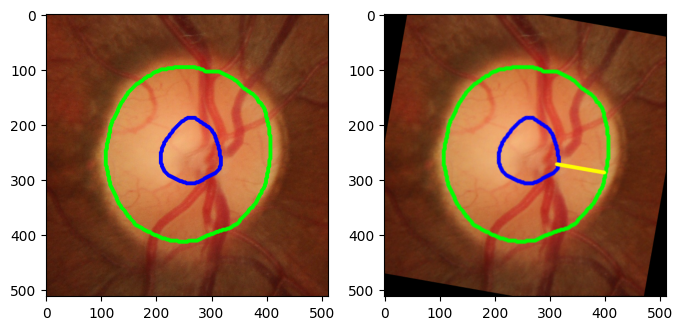

In [108]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
ax1.imshow(bound)
ax2.imshow(rotated)
cv2.imwrite('Annotated1.png', bound)
cv2.imwrite('Annotated2.png', rotated)

```

# ### Disc prediction
# In[8]:
"""
disc_pred = disc_model.predict(np.array([img_r]))
print(np.array([img_r]))
print(disc_pred)
# : This line clips the values of disc_pred between 0 and 1 using the np.clip function
disc_pred = np.clip(disc_pred, 0, 1)
# It checks if the values in disc_pred are greater than 0.5 and converts them to integers
pred_disc = (disc_pred[0, :, :, 0] > 0.5).astype(int)
# pred_disc = resize(pred_disc, (512, 512))
pred_disc = 255*pred_disc#.*(pred_disc - np.min(pred_disc))/(np.max(pred_disc)-np.min(pred_disc))
cv2.imwrite('temp_disc.png', pred_disc)


# In[9]:
#figure 2
# mask
disc = cv2.imread('temp_disc.png', cv2.IMREAD_GRAYSCALE)
#plt.figure()
#plt.imshow(disc, cmap='gray')
#plt.title('temp disc 9')

# In[10]:
#figure 3
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
ax1.imshow(pred_disc, cmap='gray')
ax1.set_title('Predicted disc 10')
ax2.imshow(true_disc, cmap='gray')
ax2.set_title('True disc 10')
#dice similarity eya
p0 = resize(disc, (512, 512))
t0 = resize(true_disc, (512, 512))
t1 = np.array(t0)
p1= np.array(p0)
intersection = np.logical_and(t1, p1)
dice = (2.0 * intersection.sum()) / (t1.sum() + p1.sum())
print('dice similarity disc',dice)
#fin dice
# In[11]:


masked = cv2.bitwise_and(img, img, mask=disc)
plt.figure()
plt.imshow(masked)
plt.show()
plt.title('masked 11')
mb, mg, mr = cv2.split(masked)
masked = cv2.merge((mb, mb, mb))

plt.figure()
plt.imshow(masked)
plt.show()
plt.title('bleu mask')
# ### cup prediction

# In[12]:

#masked=cv2.GaussianBlur(masked, (5,5), 0)
cup_pred = cup_model.predict(np.array([masked]))
pred_cup = (cup_pred[0, :, :, 0] > 0.5).astype(int)
pred_cup = cv2.bilateralFilter(cup_pred[0, :, :, 0], 10, 40, 20)
pred_cup = (pred_cup > 0.5).astype(int)
pred_cup = resize(pred_cup, (512, 512))
pred_cup = 255.*(pred_cup - np.min(pred_cup)) /(np.max(pred_cup)-np.min(pred_cup))
cv2.imwrite('temp_cup.png', pred_cup)


# In[13]:


cup = cv2.imread('temp_cup.png', cv2.IMREAD_GRAYSCALE)

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
ax1.imshow(cup, cmap='gray')
ax2.imshow(true_cup, cmap='gray')
ax1.set_title('Predicted cup13')
ax2.set_title('True cup13')
#diceS eya
p0 = resize(cup, (512, 512))
t0 = resize(true_cup, (512, 512))
t1 = np.array(t0)
p1= np.array(p0)
intersection = np.logical_and(t1, p1)
dice = (2.0 * intersection.sum()) / (t1.sum() + p1.sum())
print('dice similarity cup',dice)
#fin dice

# In[14]:
disc = resize(disc, (512, 512))
cv2.imwrite('temp_disc.png', disc)
disc = cv2.imread('temp_disc.png', cv2.IMREAD_GRAYSCALE)
(thresh, disc) = cv2.threshold(disc, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
cv2.imwrite('temp_disc.png', disc)
(thresh, cup) = cv2.threshold(cup, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
# In[15]:
cup_img = Image.open('temp_cup.png')
disc_img = Image.open('temp_disc.png')
# # ISNT

# In[16]:
isnt, cup_dias = ISNT(cup, disc, 'r')
print("\nI : {}\nS : {}\nN : {}\nT : {}".format(
    isnt[0], isnt[1], isnt[2], isnt[3]))

if isnt[0] > isnt[1] > isnt[2] > isnt[3]:
    print("\nNot Suspicious")
else:
    print("\nSuspicious l'observation n'est pas conforme à ce qui est considéré comme normal")
# # DDLS

# In[17]:
ddls, disc_dias, minrim, minang, minind = DDLS(cup_img, disc_img, 5)
print("DDLS : %.5f" % ddls)
# # CDR

# In[18]:
ver_cdr = cup_dias[0]/disc_dias[0]
print("Vertical CDR : %.5f" % ver_cdr)

hor_cdr = cup_dias[1]/disc_dias[1]
print("Horizontal CDR : %.5f" % hor_cdr)

#cdr=(ver_cdr+hor_cdr)/2
#print ("CDR : %.5f" % cdr)
# ## plots

# In[19]:
"""
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(12, 6))
ax1.set_title("Image 19")
ax1.imshow(contour_img)
ax2.set_title("Disc19")
ax2.imshow(disc, cmap='gray')
ax3.set_title("Cup19")
ax3.imshow(cup, cmap='gray')
"""

# ### contour plot

# In[21]:
#methode de detection de contours avec la methode de seuillage
#contour disc
ret,thresh_disc = cv2.threshold(disc,127,255,0)
# image_contour, (in case the next line gives error for number of expected values remove the comment from this line)
contours_disc, hierarchy = cv2.findContours(thresh_disc , cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
bound_disc = cv2.drawContours(contour_img, contours_disc, 0, (0,255,0), 5)
#contour cup
ret,thresh_cup = cv2.threshold(cup,127,255,0)
# image, (in case the next line gives error for number of expected values remove the comment from this line)
contours_cup, hierarchy = cv2.findContours(thresh_cup,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
bound = cv2.drawContours(bound_disc, contours_cup, 0, (0,0,255), 5)

disc = imutils.rotate(disc, minang)
d_b = 0
for i in range(disc.shape[0]):
    if disc[i][minind] == 255:
        break
    else:
        d_b += 1

rotated = imutils.rotate(bound, minang)
lined = cv2.line(rotated, (minind, d_b+1), (minind, d_b + minrim+3), (255, 255, 0), 5)

rotated = imutils.rotate(lined, 360-minang)

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
ax1.imshow(bound)
ax2.imshow(rotated)
cv2.imwrite('Annotated1.png', bound)
cv2.imwrite('Annotated2.png', rotated)
# In[ ]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2, y_true)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)
"""
```

